##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
!pip install -q tensorflow_datasets

In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](../load_data/text.ipynb) for details on how to load this sort of data manually.


In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFU24YR/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFU24YR/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFU24YR/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'The name of this film alone made me want to see just what it was all about, so I taped this film during the early hours of the AM. If you ever wanted to see what miners had to go through during the early days and actually see a dramatic scene when the mine crumbles in on the men. This film clearly wants to show that Germany and France can work together and be friends after WW I and how the Germans came to the aid of the French miners much to the unbelief of the French townsfolk. The actors were all outstanding, with unusual scenes in the mine with a horse and a small young boy who worked in the mine. There is an old old retired miner who manges to go down the mine by ladder when the elevator breaks down. If you are a real film buff, this is a film you will not want to miss.'
 b"OK I'll be honest, when I first saw the trailer for the programme, I thought it was an advert for some sun-screen product. With all the people walking around on the beach. Despite this I decided to wa

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [10]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2, 398,   5, ...,   0,   0,   0],
       [597, 527,  28, ...,   0,   0,   0],
       [  2, 315,   5, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasns for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The name of this film alone made me want to see just what it was all about, so I taped this film during the early hours of the AM. If you ever wanted to see what miners had to go through during the early days and actually see a dramatic scene when the mine crumbles in on the men. This film clearly wants to show that Germany and France can work together and be friends after WW I and how the Germans came to the aid of the French miners much to the unbelief of the French townsfolk. The actors were all outstanding, with unusual scenes in the mine with a horse and a small young boy who worked in the mine. There is an old old retired miner who manges to go down the mine by ladder when the elevator breaks down. If you are a real film buff, this is a film you will not want to miss.'
Round-trip:  the name of this film alone made me want to see just what it was all about so i [UNK] this film during the early hours of the am if you ever wanted to see what [UNK] had to go through duri

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [16]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00355472]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [17]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00355472]


Compile the Keras model to configure the training process:

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 33s 84ms/step - loss: 0.6490 - accuracy: 0.5585 - val_loss: 0.5634 - val_accuracy: 0.7250
Epoch 2/10
391/391 [==============================] - 31s 79ms/step - loss: 0.4838 - accuracy: 0.7561 - val_loss: 0.4380 - val_accuracy: 0.7635
Epoch 3/10
391/391 [==============================] - 31s 79ms/step - loss: 0.3858 - accuracy: 0.8265 - val_loss: 0.3757 - val_accuracy: 0.8370
Epoch 4/10
391/391 [==============================] - 31s 79ms/step - loss: 0.3497 - accuracy: 0.8472 - val_loss: 0.3576 - val_accuracy: 0.8495
Epoch 5/10
391/391 [==============================] - 31s 79ms/step - loss: 0.3299 - accuracy: 0.8582 - val_loss: 0.3422 - val_accuracy: 0.8458
Epoch 6/10
391/391 [==============================] - 31s 78ms/step - loss: 0.3232 - accuracy: 0.8614 - val_loss: 0.3396 - val_accuracy: 0.8469
Epoch 7/10
391/391 [==============================] - 31s 79ms/step - loss: 0.3137 - accuracy: 0.8667 - val_loss: 0.3303 - val_accuracy:

In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 13s 34ms/step - loss: 0.3196 - accuracy: 0.8610
Test Loss: 0.3196291923522949
Test Accuracy: 0.8610000014305115


(0.0, 0.6664391979575157)

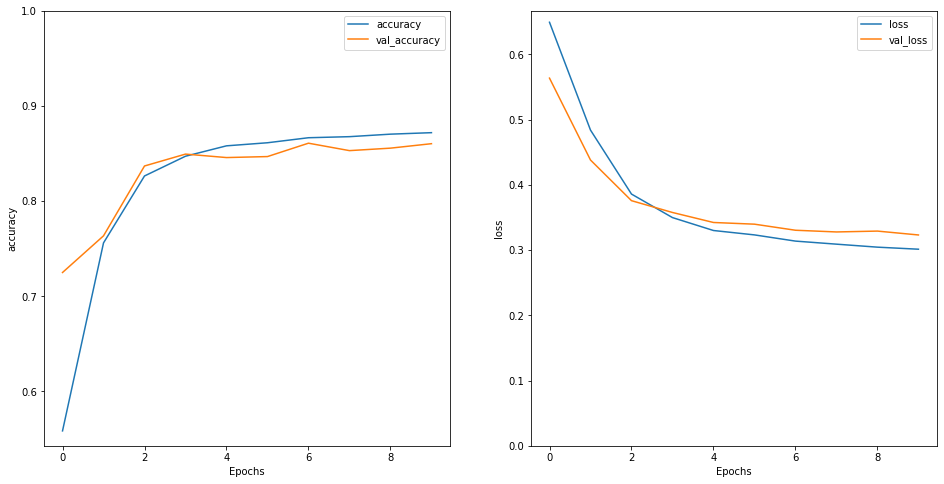

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

Run a prediction on a neew sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [22]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/layered_bidirectional.ipynb?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 58s 148ms/step - loss: 0.6566 - accuracy: 0.5545 - val_loss: 0.4766 - val_accuracy: 0.7495
Epoch 2/10
391/391 [==============================] - 54s 139ms/step - loss: 0.3998 - accuracy: 0.8234 - val_loss: 0.3556 - val_accuracy: 0.8443
Epoch 3/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3402 - accuracy: 0.8529 - val_loss: 0.3394 - val_accuracy: 0.8594
Epoch 4/10
391/391 [==============================] - 54s 139ms/step - loss: 0.3233 - accuracy: 0.8610 - val_loss: 0.3672 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3144 - accuracy: 0.8638 - val_loss: 0.3229 - val_accuracy: 0.8516
Epoch 6/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3073 - accuracy: 0.8663 - val_loss: 0.3221 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3041 - accuracy: 0.8684 - val_loss: 0.3184 - val_ac

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 24s 62ms/step - loss: 0.3207 - accuracy: 0.8630
Test Loss: 0.3207439184188843
Test Accuracy: 0.8629599809646606


In [27]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.8912907]]


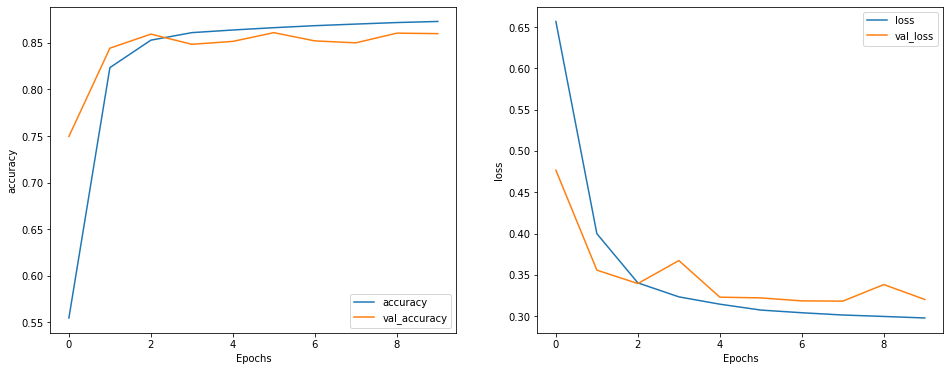

In [28]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')